# House Prices: Advanced Regression Techniques
The goal is to predict sales prices of houses using data from Kaggle's ["House Prices: Advanced Regression Techniques"](https://www.kaggle.com/c/house-prices-advanced-regression-techniques) competition. The training and testing data each include roughly 1,500 recent house sales in Ames, Iowa. 79 house features are included, such as lot area, number of fireplaces, kitchen quality, and neighborhood. Predictive accuracy is measured by the root-mean-squared error between the logarithm of predicted sale price and the logarithm of true sale price.

In [68]:
import pandas as pd
import numpy as np
import math, operator
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Lasso, LassoCV, Ridge, RidgeCV
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor

In [69]:
df = pd.read_csv('train.csv')
print df.shape
df.head()

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


`data_description.txt` explains how each feature is measured. Some categorical features have a clear ordering by buyer preference &mdash; most have "Quality" or "Condition" in their names &mdash; and can be converted immediately into quantized features.

### Pre-processing functions

In [70]:
def convert_qualities(df):
    # RETURN: a copy of `df` with changed/added features:
    #   1. Categorical features with clear value ordering are numbered.
    #   2. NaN's are filled with either zero or the feature median, whichever seems more appropriate.
    
    df_ = df.copy()
    
    # convert qualities and conditions into numbered scale
    quality_dict = {'Ex':1, 'Gd':0.8, 'TA':0.6, 'Fa':0.4, 'Po':0.2}
    quality_keys = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
                    'HeatingQC', 'PoolQC', 'KitchenQual', 'FireplaceQu',
                    'GarageQual', 'GarageCond']
    for key in quality_keys:
        df_[key] = [0.1 if val!=val else quality_dict[val] for val in df_[key]]
    
    # convert basement finish and exposure
    bsmt_dict = {'GLQ':1, 'ALQ':0.9, 'BLQ':0.8, 'Rec':0.6,
                 'LwQ':0.3, 'Unf':0.2, 'NA':0.1}    
    for key in ['BsmtFinType1', 'BsmtFinType2']:
        df_[key] = [0.1 if val!=val else bsmt_dict[val] for val in df_[key]]
    bsmt_dict = {'Gd':1, 'Av':0.8, 'Mn':0.6, 'No':0.4, 'NA':0.1}    
    for key in ['BsmtExposure']:
        df_[key] = [0.1 if val!=val else bsmt_dict[val] for val in df_[key]]
        
    # convert functional
    functional_dict = {'Typ':1, 'Min1':0.8, 'Min2':0.6, 'Mod':0.5,
                       'Maj1':0.4, 'Maj2':0.3, 'Sev':0.2, 'Sal':0.1}
    df_['Functional'] = [0.5 if val!=val else functional_dict[val] for val in df_['Functional']]
    
    # convert fence
    fence_dict = {'GdPrv':1., 'MnPrv':0.8, 'GdWo':0.6, 'MnWw':0.8, 'NA':0.1}
    df_['Fence'] = [0.1 if val!=val else fence_dict[val] for val in df_['Fence']]
    
    # revert SubClass to string; other code will realize they are categories
    df_['MSSubClass'] = ['No_Value' if val!=val else '%i'%val for val in df_['MSSubClass']]
    
    # fill NaN's with appropriate replacements
    df_['LotFrontage'] = [70 if val!=val else val for val in df_['LotFrontage']]
    df_['GarageYrBlt'] = [0 if val!=val else val for val in (df_['GarageYrBlt']-1900)]
    df_['YearRemodAdd'] = [0 if val!=val else val for val in (df_['YearRemodAdd']-1900)]
    df_['YearBuilt'] = [50 if val!=val else val for val in (df_['YearBuilt']-1900)]
    df_['YrSold'] = [50 if val!=val else val for val in (df_['YrSold']-1900)]
    df_['2ndFlrSF_reg'] = [val if val>0.01 else 700 for val in df_['2ndFlrSF']]
    df_['GarageArea_reg'] = [val if val>0.01 else 250 for val in df_['GarageArea']]
    df_['TotalBsmtSF_reg'] = [val if val>0.01 else 400 for val in df_['TotalBsmtSF']]
    
    # paved beats gravel
    df_['Street'] = [1 if val=='Pave' else 0 for val in df_['Street']]
    # go with Has_alley
    df_['Alley'] = [1 if val==val else 0 for val in df_['Alley']]
    # fill veneer values
    df_['MasVnrArea'] = [0 if val!=val else val for val in df_['MasVnrArea']]
    df_['MasVnrType'] = ['None' if val!=val else val for val in df['MasVnrType']]
    
    return df_

def detect_categories(df):
    # RETURN: a list of keys corresponding to categorical features in `df`
    cat_keys = []
    for key in df.keys():
        is_string = [isinstance(value, str) and (value==value) for value in df[key]]
        if sum(is_string) > 0:
            cat_keys.append(key)
    
    return cat_keys

def onehot_categories(df, cat_keys):
    # RETURN: a dataframe of all OneHot arrays for categorical keys in `df`
    # `cat_keys`: a list of strings, keys corresponding to categorical features in `df`
    
    df_ = df.loc[:][cat_keys]
    for key in cat_keys:
        df_[key] = ['No_Value' if val!=val else val for val in df_[key]]
    enc = OneHotEncoder()
    df_ = pd.get_dummies(df_, prefix=cat_keys)
    # Group correlated neighborhoods; found to improve regression results
    if 'Neighborhood' in cat_keys:
        df_['Good_Neigh'] = df_['Neighborhood_NoRidge']+df_['Neighborhood_NridgHt']+df_['Neighborhood_StoneBr']
        df_['Bad_Neigh'] = df_['Neighborhood_OldTown']+df_['Neighborhood_NAmes']+df_['Neighborhood_Edwards']
        df_['Bad_Neigh'] += df_['Neighborhood_IDOTRR']+df_['Neighborhood_BrkSide']+df_['Neighborhood_Sawyer'] 
    
    return df_

def make_new_keys(df):
    # RETURN: a copy of `df` with some new features that improve regression results
    # for example, the sum of baths is significantly more correlated with 'SalePrice' than any single bath feature
    
    df_ = df.copy()
    df_['TotalBath'] = df_['HalfBath']*0.51 + df_['FullBath'] + df_['BsmtHalfBath']*0.501 + df_['BsmtFullBath']
    df_['Age'] = (df_['YrSold'] - df_['YearBuilt'])**.5 # price scales better with SQRT(Age)
    df_['BSMT'] = df_['TotalBsmtSF']*df_['BsmtQual']
    
    return df_

def regularize(train, test):
    # RETURN: copies of `train` and `test` dataframes with numerical keys regularized
    #   1. significant outliers are bound to 10% greater than the 99th percentile
    #   2. feature range is regularized to [0,1] for linear regressor
    # `train`: training dataframe, sets parameters for regularization
    # `testing`: testing dataframe
    
    train_ = train.copy()
    for key in train.keys():
        tempmax, tempmin, pct99 = max(train_[key]), min(train_[key]), np.percentile(train_[key], 99)
        if tempmax > 1.1*pct99:
            train_[key] = [1.1*pct99 if val>pct99 else val for val in train_[key]]
            test_[key] = [1.1*pct99 if val>pct99 else val for val in test_[key]]
        train_[key] = (train_[key]-tempmin) / (tempmax-tempmin)
        test_[key] = (test_[key]-tempmin) / (tempmax-tempmin)
    
    return train_, test_

In [71]:
df = pd.read_csv('train.csv')
df = convert_qualities(df)
df = make_new_keys(df)
print (df.corr()['SalePrice']).sort_values()

Age               -0.570671
Fence             -0.155337
KitchenAbvGr      -0.135907
EnclosedPorch     -0.128578
Alley             -0.123611
OverallCond       -0.077856
YrSold            -0.028923
LowQualFinSF      -0.025606
Id                -0.021917
MiscVal           -0.021190
BsmtFinType2      -0.019476
BsmtHalfBath      -0.016844
BsmtFinSF2        -0.011378
ExterCond          0.018899
Street             0.041036
3SsnPorch          0.044584
MoSold             0.046432
PoolArea           0.092404
Functional         0.111030
ScreenPorch        0.111447
PoolQC             0.113473
BedroomAbvGr       0.168213
BsmtUnfSF          0.214479
BsmtCond           0.216631
BsmtFullBath       0.227122
LotArea            0.263843
GarageCond         0.264992
BsmtFinType1       0.266224
GarageQual         0.277261
HalfBath           0.284108
OpenPorchSF        0.315856
2ndFlrSF           0.319334
WoodDeckSF         0.324413
LotFrontage        0.334897
BsmtExposure       0.377896
BsmtFinSF1         0

In [72]:
def get_keys_passing_thresh(df, threshold):
    # RETURN: a list of keys corresponding to features in `df` that have 
    #         correlation coefficients with 'SalePrice' greater than `threshold`
    # `threshold`: sets a lower limit for the absolute value of coefficients
    
    cat_keys = detect_categories(df)
    df_cat = onehot_categories(df[cat_keys], cat_keys)
    df_cat['SalePrice'] = df['SalePrice']

    # do numbered features
    CORR = df.corr()['SalePrice']
    CORR = sorted(CORR.items(), key=operator.itemgetter(1))
    num_labels = np.array([pair[0] for pair in CORR]); num_corr = np.abs([pair[1] for pair in CORR])
    num_passing = num_labels[num_corr>threshold]

    # do OneHots
    CORR = df_cat.corr()['SalePrice']
    CORR = sorted(CORR.items(), key=operator.itemgetter(1))
    cat_labels = np.array([pair[0] for pair in CORR]); cat_corr = np.abs([pair[1] for pair in CORR])
    cat_passing = cat_labels[cat_corr>threshold]

    KEYS = np.append(num_passing[:-1],cat_passing[:-1])
    return KEYS

threshold = 0.2
KEYS = get_keys_passing_thresh(df, threshold)
print "Features with |CorrCoef|>%.2f selected.   %i features used for regression."%(threshold, len(KEYS))

Features with |CorrCoef|>0.20 selected.   74 features used for regression.


In [73]:
df = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

df = convert_qualities(df); test = convert_qualities(test)
df = make_new_keys(df); test = make_new_keys(test)
catdf = detect_categories(df); cattest = detect_categories(test)
df_cat = onehot_categories(df[catdf], catdf); test_cat = onehot_categories(test[catdf], cattest)
df_ = pd.concat([df,df_cat], axis=1); test_ = pd.concat([test,test_cat], axis=1)

# train/test may have different OneHot features:
#   check if feature is missing and fill with array of zeros if needed
unq_keys = np.unique(np.append(df_.keys(), test_.keys()))
for key in unq_keys:
    if key not in df_.keys(): df_[key]=np.zeros(len(df_))
    if key not in test_.keys(): test_[key]=np.zeros(len(test_))
df_ = df_[KEYS]; test_ = test_[KEYS]
df_, test_ = regularize(df_, test_)

train_T = df['SalePrice']

# Last-minute munging of test data. One or two NaNs in some features here.
test_['Age'] = [val if val<1000 else 50 for val in test_['Age']]
test_['TotalBath'] = [val if val==val else 2 for val in test_['TotalBath']]
for key in ['BsmtUnfSF', 'BsmtFullBath', 'BsmtFinSF1', 'TotalBsmtSF', 'GarageArea', 'GarageCars', 'BSMT']:
    test_[key] = [val if val==val else 0 for val in test_[key]]

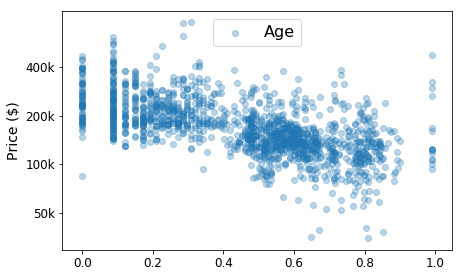

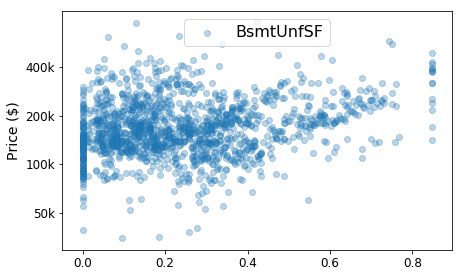

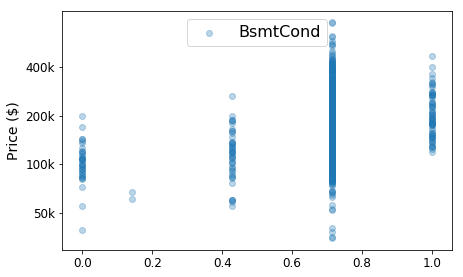

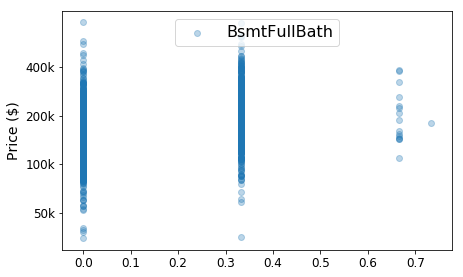

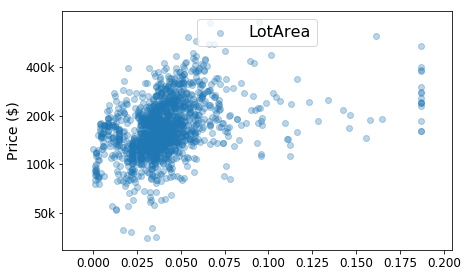

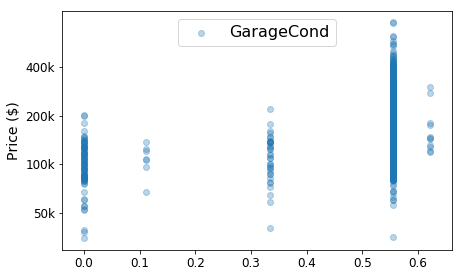

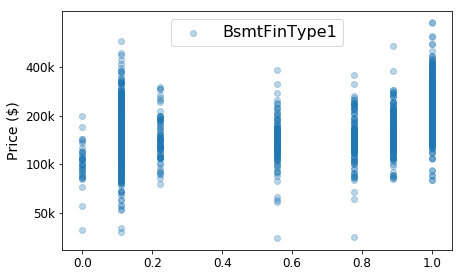

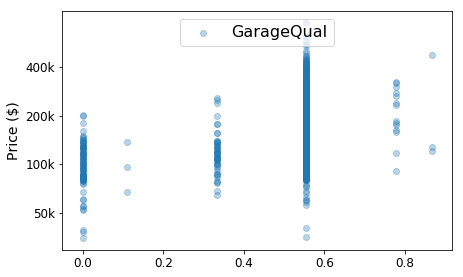

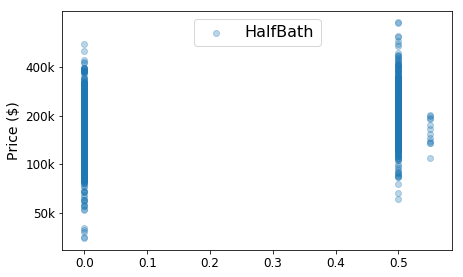

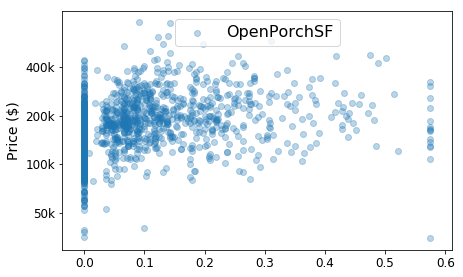

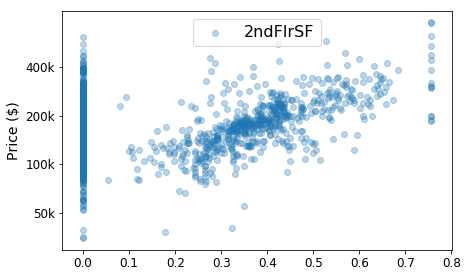

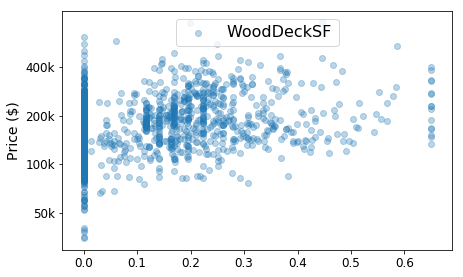

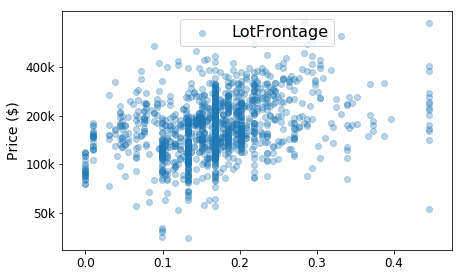

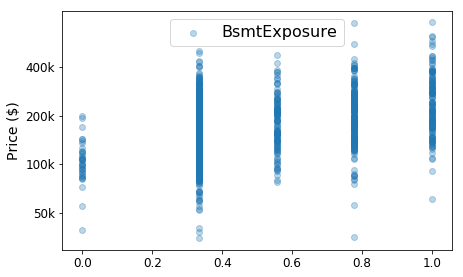

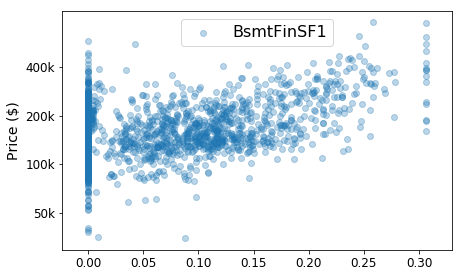

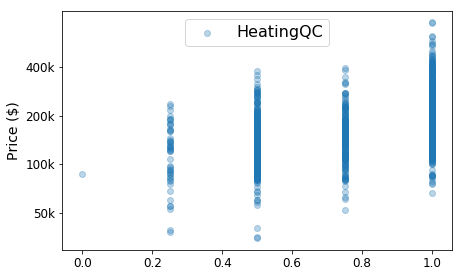

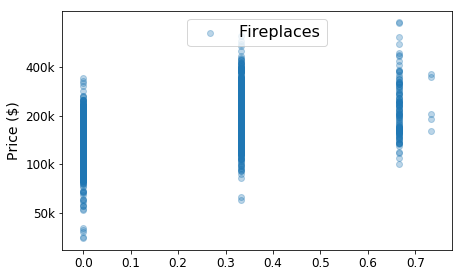

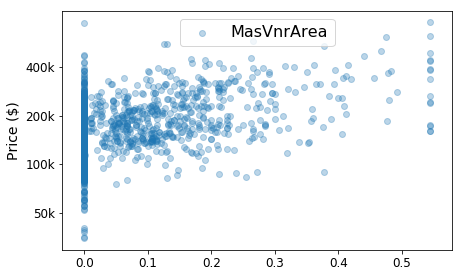

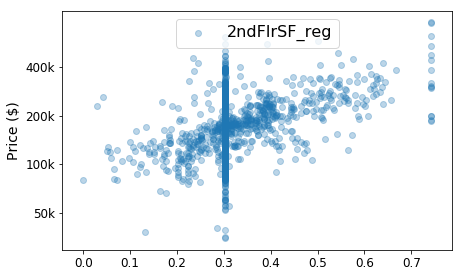

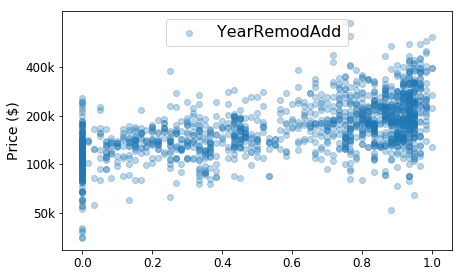

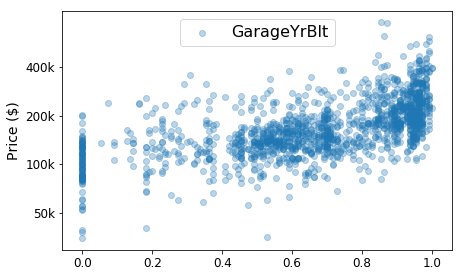

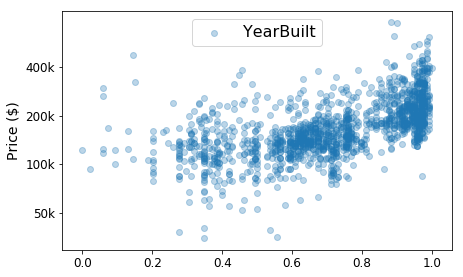

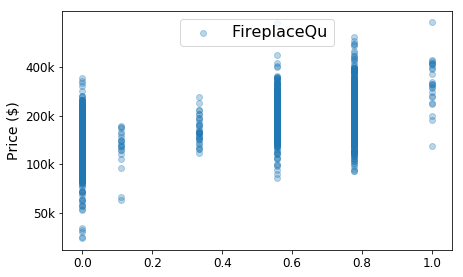

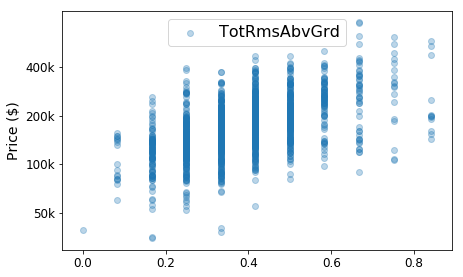

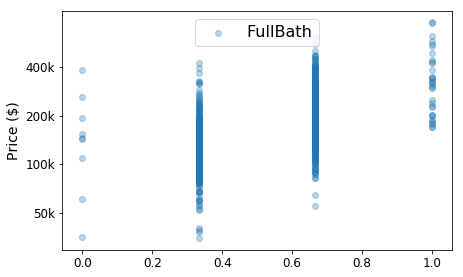

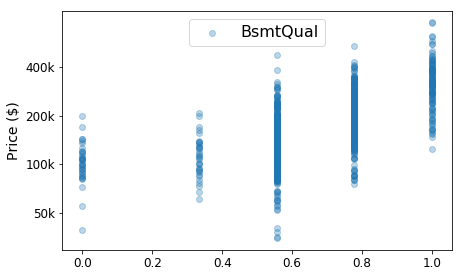

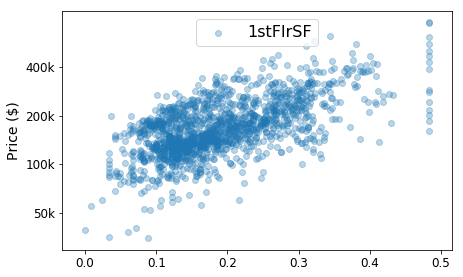

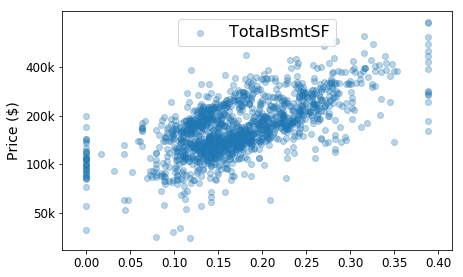

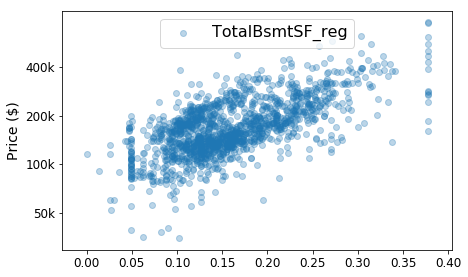

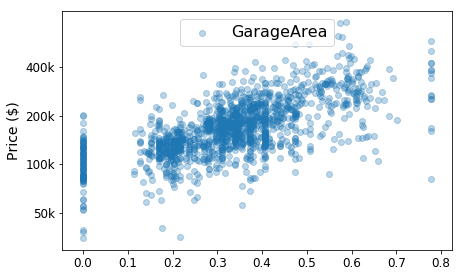

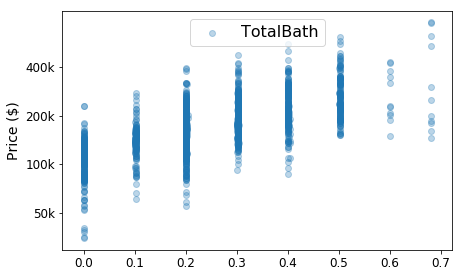

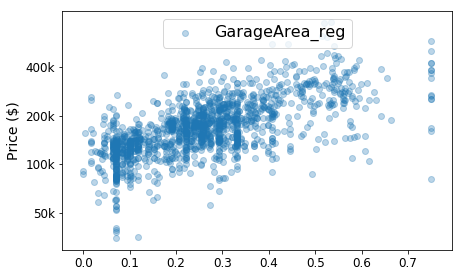

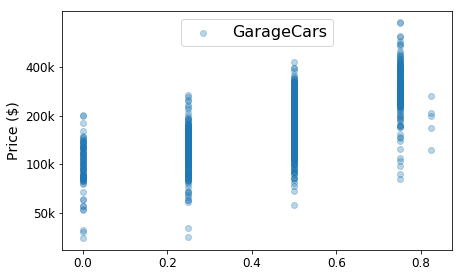

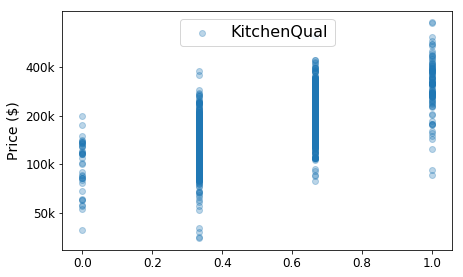

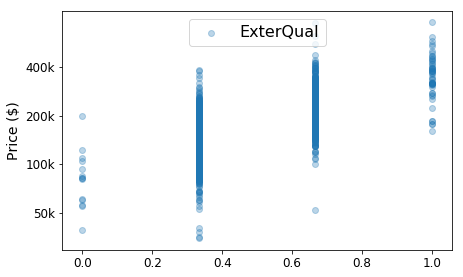

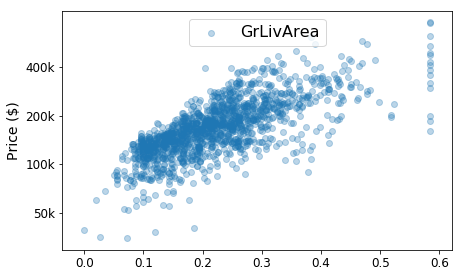

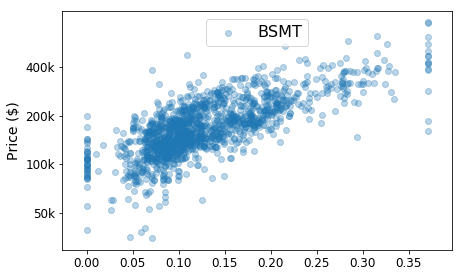

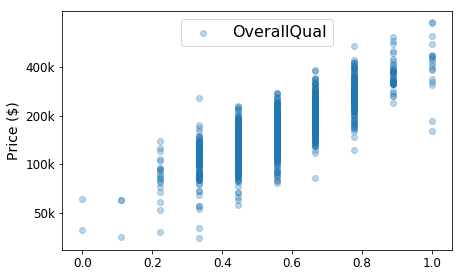

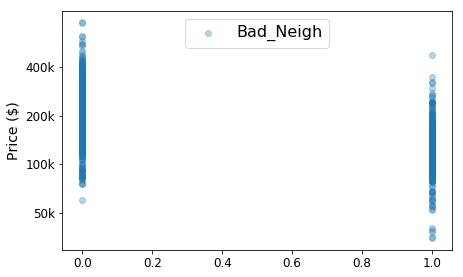

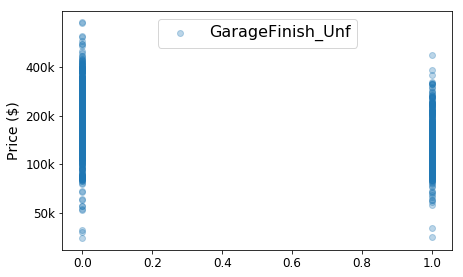

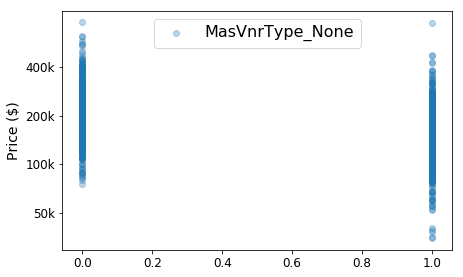

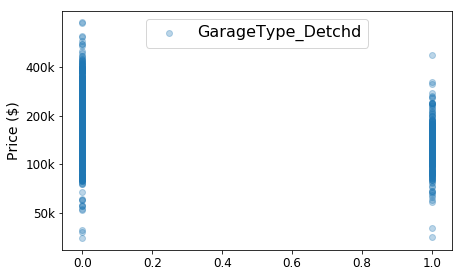

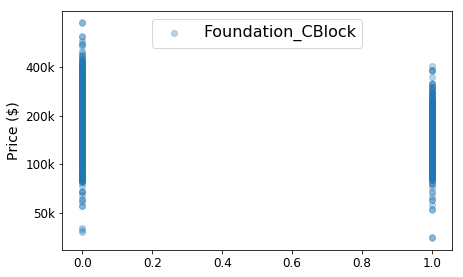

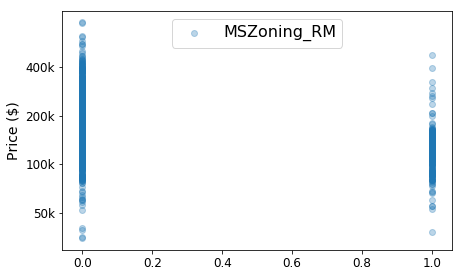

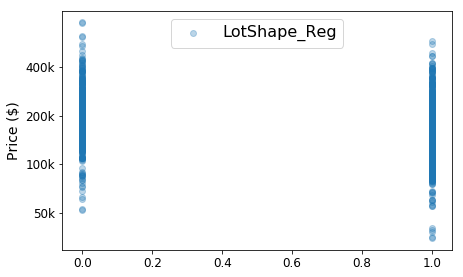

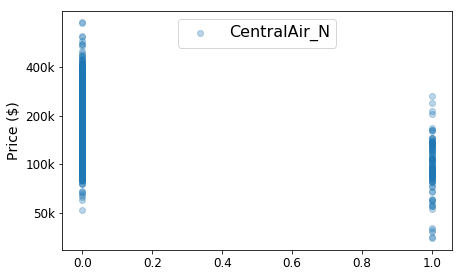

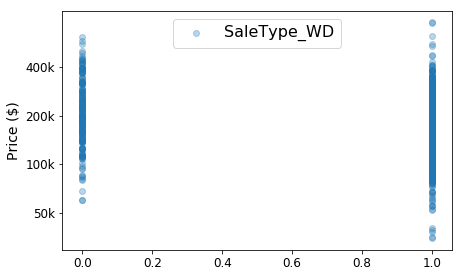

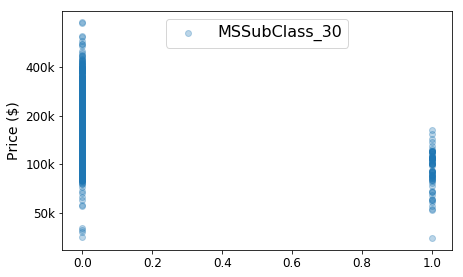

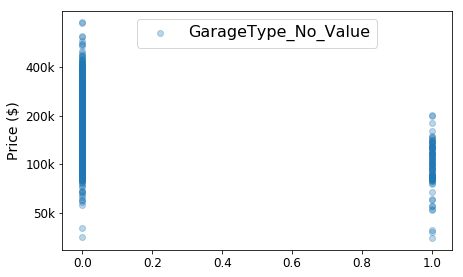

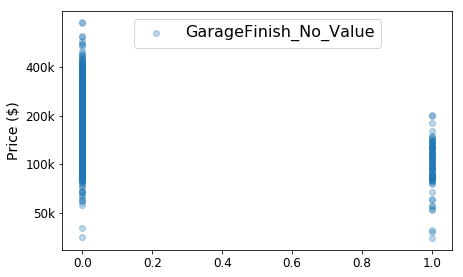

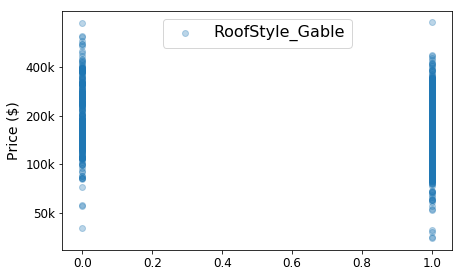

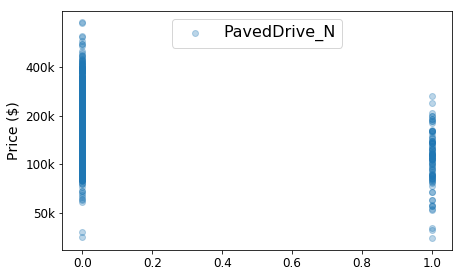

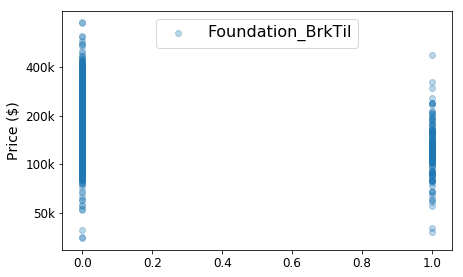

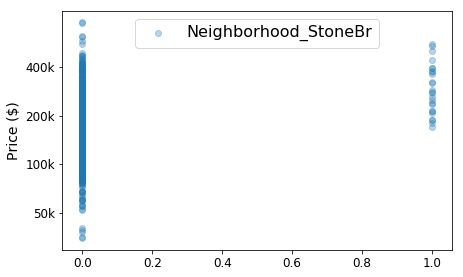

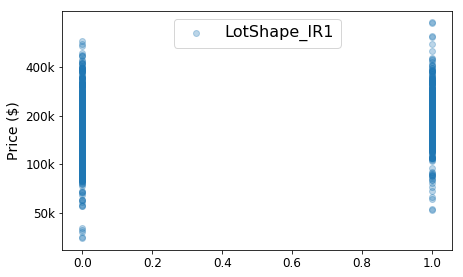

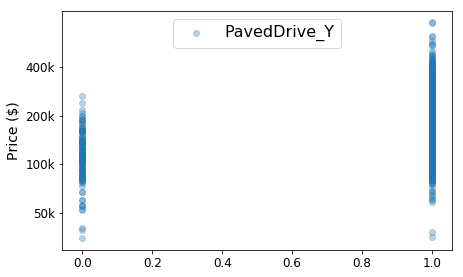

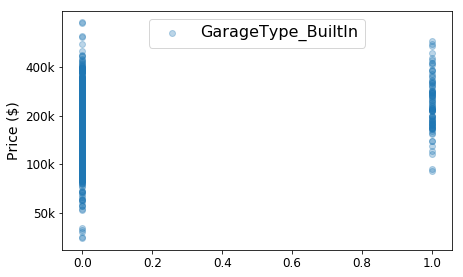

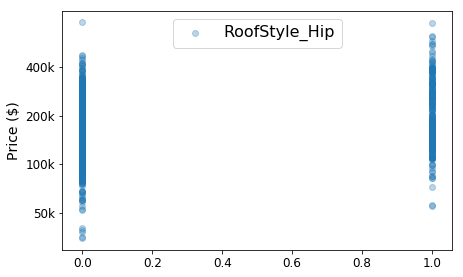

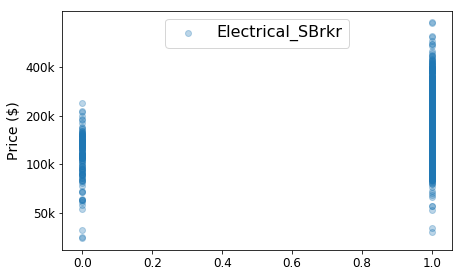

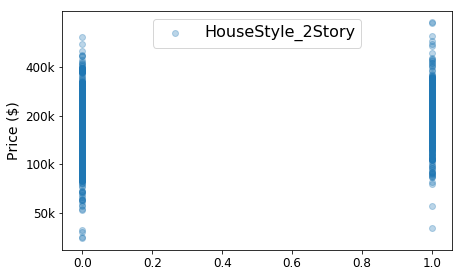

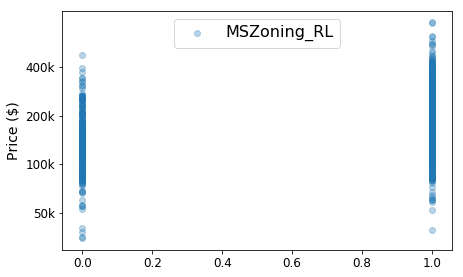

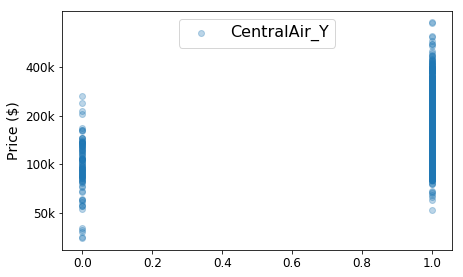

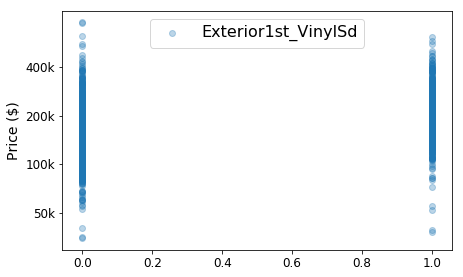

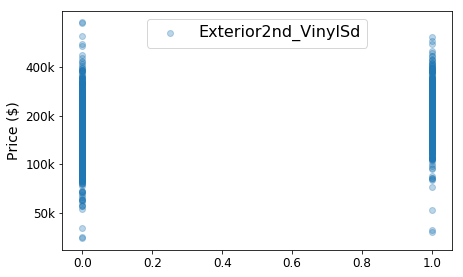

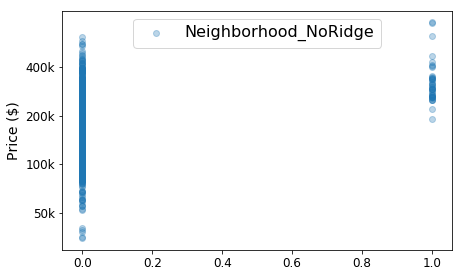

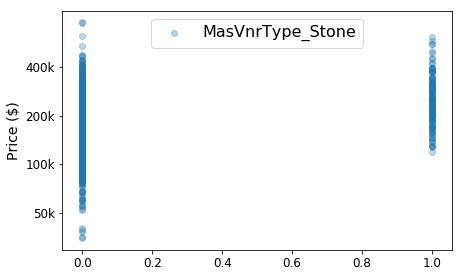

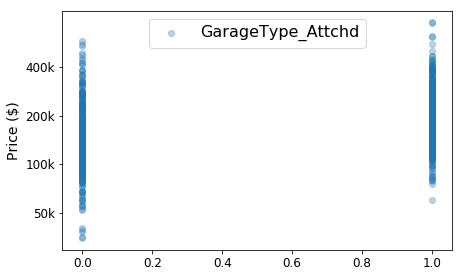

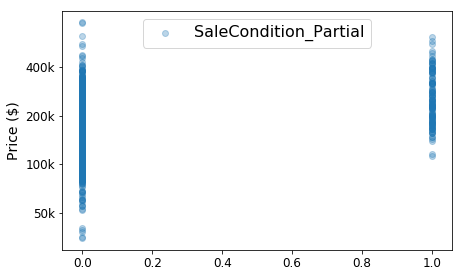

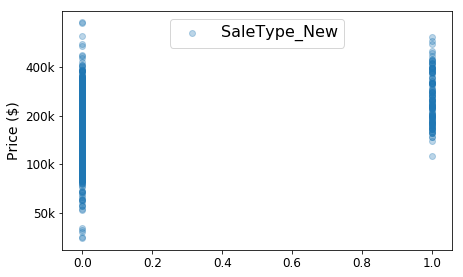

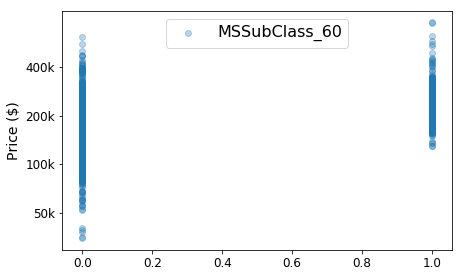

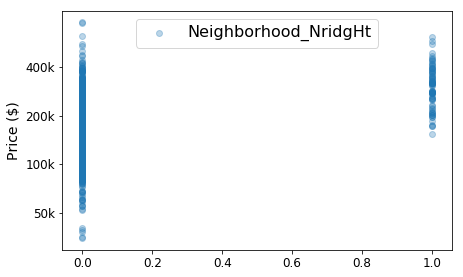

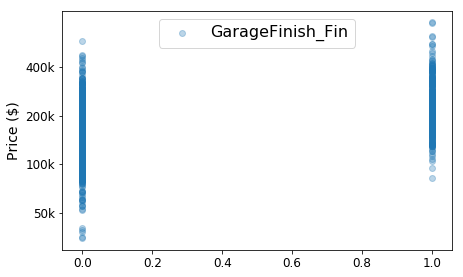

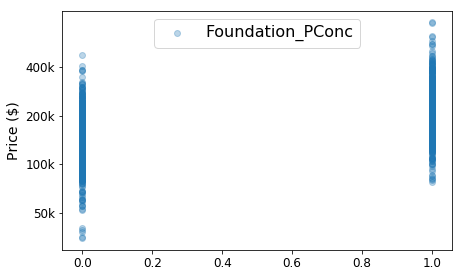

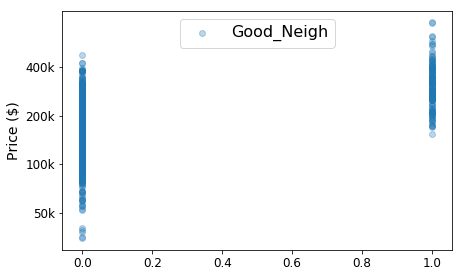

In [46]:
for key in KEYS:
    fig, ax = plt.subplots(figsize=(7,4.4))
    ax.scatter(df_[key], np.log(train_T), alpha=0.3, label=key)
    ax.legend(loc=9, fontsize=16); ax.set_ylabel('Price ($)', fontsize=14)
    ax.set_yticks(np.log([5e4, 1e5, 2e5, 4e5])); ax.set_yticklabels(['50k','100k','200k','400k'])
    fig.show()

In [47]:
fitter = LassoCV(alphas=np.logspace(-5,-2,num=200))
fitter.fit(df_, np.log(train_T))
pred_lasso = np.exp(fitter.predict(test_))
print "alpha = ", fitter.alpha_

RFR = RandomForestRegressor(n_estimators=20, n_jobs=10, min_samples_leaf=1)
fitter = AdaBoostRegressor(RFR, n_estimators=60, random_state=2018)
fitter.fit(df_, np.log(train_T))
pred_forest = np.exp(fitter.predict(test_))

/home/samfahey/.local/lib/python2.7/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


alpha =  0.00041026581058271905


In [17]:
low, high = np.percentile(pred_lasso, [20,80])

# Use random forest
# if prediction is outside of central 60%, average with Lasso
prediction = pred_lasso.copy()
for i in range(len(pred_lasso)):
    if pred_lasso[i]>low and pred_lasso[i]<high: prediction[i] = (pred_lasso[i]+pred_forest[i])/2.

In [18]:
df_submit = pd.DataFrame({'Id':test['Id'], 'SalePrice':prediction})
df_submit.to_csv('submission_07.csv', index=False)

# Score: 0.12230 (RMS log error)
**Currently 1145th place (75th percentile)**

### Testing Material

In [63]:
df = pd.read_csv('train.csv').iloc[250:]
test = pd.read_csv('train.csv').iloc[:250]

df = convert_qualities(df); test = convert_qualities(test)
df = make_new_keys(df); test = make_new_keys(test)
catdf = detect_categories(df); cattest = detect_categories(test)
df_cat = onehot_categories(df[catdf], catdf); test_cat = onehot_categories(test[catdf], cattest)
df_ = pd.concat([df,df_cat], axis=1); test_ = pd.concat([test,test_cat], axis=1)

unq_keys = np.unique(np.append(df_.keys(), test_.keys()))
for key in unq_keys:
    if key not in df_.keys(): df_[key]=np.zeros(len(df_))
    if key not in test_.keys(): test_[key]=np.zeros(len(test_))
df_ = df_[KEYS]; test_ = test_[KEYS]
df_, test_ = regularize(df_, test_)

train_T = df['SalePrice']; test_T = test['SalePrice']

fitter = LassoCV(alphas=np.logspace(-5,-2,num=200))
fitter.fit(df_, np.log(train_T))
pred1 = np.exp(fitter.predict(test_))
print "alpha = ", fitter.alpha_
print "pred_lasso error = ", np.sqrt(mean_squared_error(np.log(pred1), np.log(test_T)))

RFR = RandomForestRegressor(n_estimators=20, n_jobs=10, min_samples_leaf=1)
fitter = AdaBoostRegressor(RFR, n_estimators=60, random_state=2018)
fitter.fit(df_, np.log(train_T))
pred2 = np.exp(fitter.predict(test_))

print "pred_forest error = ", np.sqrt(mean_squared_error(np.log(pred2), np.log(test_T)))

alpha =  0.0003107866187782014
pred_lasso error =  0.130383524820527
pred_forest error =  0.13132849249059714


In [64]:
low, high = np.percentile(pred1, [20,80])
# middle is forest, otherwise average the two
pred3 = pred1.copy()
for i in range(len(pred3)):
    if pred1[i]>low and pred1[i]<high: pred3[i] = (pred1[i]+pred2[i])/2.
print "combined error = ", np.sqrt(mean_squared_error(np.log(pred3), np.log(test_T)))

combined error =  0.12925811425770486


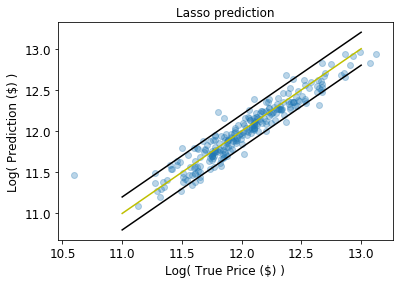

In [65]:
plt.scatter(np.log(test_T), np.log(pred1), alpha=0.3)
plt.title('Lasso prediction')
plt.ylabel('Log( Prediction ($) )'); plt.xlabel('Log( True Price ($) )')
plt.plot([11,13], [11,13], color='y')
plt.plot([11,13], [11.2,13.2], color='k')
plt.plot([11,13], [10.8,12.8], color='k')

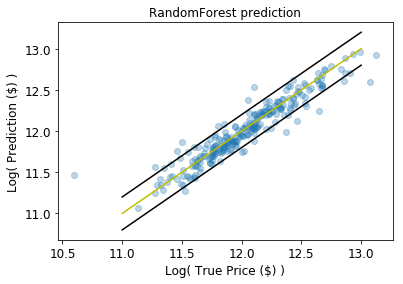

In [66]:
plt.scatter(np.log(test_T), np.log(pred2), alpha=0.3)
plt.title('RandomForest prediction')
plt.ylabel('Log( Prediction ($) )'); plt.xlabel('Log( True Price ($) )')
plt.plot([11,13], [11,13], color='y')
plt.plot([11,13], [11.2,13.2], color='k')
plt.plot([11,13], [10.8,12.8], color='k')

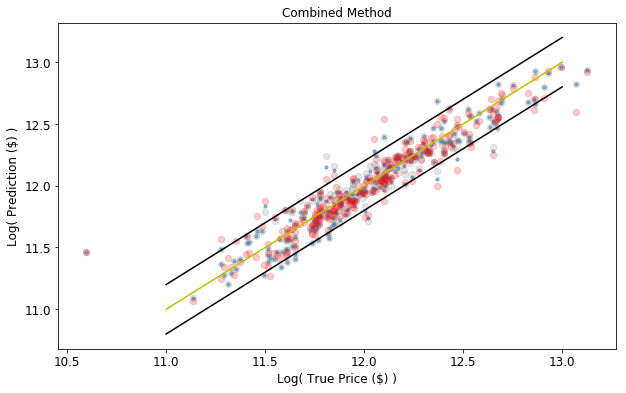

In [67]:
fig, ax = plt.subplots(figsize=(10,6))

ax.scatter(np.log(test_T), np.log(pred3), alpha=0.5, s=10)
ax.scatter(np.log(test_T), np.log(pred1), c='gray', alpha=0.2, s=40)
ax.scatter(np.log(test_T), np.log(pred2), c='r', alpha=0.2, s=40)
ax.plot([11,13], [11,13], color='y')
ax.plot([11,13], [11.2,13.2], color='k')
ax.plot([11,13], [10.8,12.8], color='k')
ax.set_title('Combined Method')
ax.set_ylabel('Log( Prediction ($) )'); ax.set_xlabel('Log( True Price ($) )')
fig.show()